In [1]:
import numpy as np
import pandas as pd
import scipy as sc
import matplotlib.pyplot as plt
import pickle
import os,sys
import pyxdf as xdf
import torch
from torch.utils.data import DataLoader
import seaborn as sns
from sklearn.metrics import mean_squared_error
sys.path.append("../models/model_based_files/")
#sys.path.append("../models/Data_based_models/transformer_1/")
sys.path.append("../models/Data_based_models/Self_Attention/")
from Speed_Recognition_3 import SpeedRecProcessing as SRP
from model_2 import Speed_model_2 as SP
from model2 import CNN as CLSTM
#from model2 import ResidualBlock as RB
#from model2 import CNN_LSTM as CLSTM
from preprocessing1 import preprocess,split
from dataset import IMU

/home/prestige/Documents/venvs/activity_class/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
sns.set_style('darkgrid') # darkgrid, white grid, dark, white and ticks
sns.set_color_codes('dark')
plt.rc('axes', titlesize=30)     # fontsize of the axes title
plt.rc('axes', labelsize=25)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=25)    # fontsize of the tick labels
plt.rc('ytick', labelsize=25)    # fontsize of the tick labels
plt.rc('legend', fontsize=25)    # legend fontsize
plt.rc('lines', linewidth=1.5)
plt.rc('font', size=25)      

In [3]:
model=CLSTM(num_classes=1)

model.load_state_dict(torch.load("../models/Data_based_models/Self_Attention/model_4_39.h5"))
norm=pickle.load(open('../models/Data_based_models/Self_Attention/normalizer.pickle','rb'))


In [4]:
def data_prep(data,label):
        X,Y=split(data,label

                        ,window=1,sample_rate=200,vert_acc_i=0,interval=0.5)
                #test_dataset=IMU(X,Y,size=400,num_features=6)
                #test_loader=DataLoader(test_dataset,batch_size=1)
        t=np.arange(0,1,1/200)
        X=X.reshape(X.shape[0],1,200)
                #time=np.repeat(t,X.shape[0],axis=0).reshape(X.shape[0],1,200)
                #X=np.concatenate((X,time),axis=1)
        X=X.reshape(X.shape[0],X.shape[1]*X.shape[2])
        X=norm.fit_transform(X)
        X=X.reshape(X.shape[0],1,200)[20:-20,:,:]
        print(X.shape)
        return X,Y


def Kalman_1D(state,measurement,process_var=0.005**2,measurement_var=0.05**2):
        estimate=[[],[]]
        state[0],state[1]=state[0]+0,state[1]+process_var
        estimate[0],estimate[1]=(state[1]*measurement+measurement_var*state[0])/(state[1]+measurement_var),(state[1]*measurement_var)/(state[1]+measurement_var)
        state=estimate

        return state

def kalman_filter(preds):
    values=[]
    for i,v in enumerate(preds):
        if i==0:
            state=[v,0.1**2]
            values+=[state[0]]
        else:
            state=Kalman_1D(state,v)
            values+=[state[0]]
    return values

In [5]:
l1={'1':[],'1.25':[],'1.5':[]}
l2={'1':[],'1.25':[],'1.5':[]}
l3={'1':[],'1.25':[],'1.5':[]}
l4={'1':[],'1.25':[],'1.5':[]}
a1={'1':[],'1.25':[],'1.5':[]}
a2={'1':[],'1.25':[],'1.5':[]}
a3={'1':[],'1.25':[],'1.5':[]}
extracted_data={'1':l1,'2':l2,'3':l3,'4':l4,'a1':a1,'a2':a2,'a3':a3}

df={'speeds':[],'speed':[],'subject':[],'rmse':[]}

def add_data(model,label,dict):
    dict['1'][f'{label}'].append(model.f_conv1[0,:,:].detach().numpy())
    dict['2'][f'{label}'].append(model.f_conv2[0,:,:].detach().numpy())
    dict['3'][f'{label}'].append(model.f_conv3[0,:,:].detach().numpy())
    dict['4'][f'{label}'].append(model.f_conv4[0,:,:].detach().numpy())
    dict['a1'][f'{label}'].append(model.f_attention1[0,:,:].detach().numpy())
    dict['a2'][f'{label}'].append(model.f_attention2[0,:,:].detach().numpy())
    dict['a3'][f'{label}'].append(model.f_attention3[0,:,:].detach().numpy())
    return dict
    


In [6]:
rmse=[]
std=[]
prediction=[]

for i in range(3,15):
    run=i
    path=f'../Recordings/sub-P007/pickled_data/Session_2/{run}.pickle'
    preds=[]
    with open(path,'rb') as f:
        d=pickle.load(f)
        data=d['data']
        label=d['label']
    o_label=label

    if label==0:
        label=1
    elif label==1:
        label=1.25
    elif label==2:
        label=1.5
    elif label==3:
        label=0.5
    elif label==4:
        label=0.5
    x,y=data_prep(data,label)
    
    model.eval()

    with torch.no_grad():
        for i in range(x.shape[0]):
            input=torch.from_numpy(x[i,:,:]).float().unsqueeze(0)
            output=model(input)
            preds+=output.detach().cpu()
            dict=add_data(model,label,extracted_data)
    
    preds=np.array(preds)
    preds=kalman_filter(preds)
    prediction.append(preds)
    try:
        #plt.figure()
        #plt.plot(preds)
        #print(i)
        rmse.append(np.sqrt(mean_squared_error(label*np.ones(len(preds)),preds)))
        df['speed'].append(label)
        df['speeds'].append(np.mean(preds))
        df['subject'].append('subject 2')
        
        df['rmse'].append(np.sqrt(mean_squared_error(label*np.ones(len(preds)),preds)))


        std.append(np.std(preds))
        #plt.title(f'Run {run}')
        #plt.ylim([0.5,2])
        #plt.show()
    except:
        print('error')
        continue

    

(1899, 1, 200)
(645, 1, 200)
(1663, 1, 200)
(216, 1, 200)
(1599, 1, 200)
(546, 1, 200)
(366, 1, 200)
(376, 1, 200)
(490, 1, 200)
(0, 1, 200)
error
(364, 1, 200)
(368, 1, 200)


In [7]:
l1=extracted_data['1']
l2=extracted_data['2']
l3=extracted_data['3']
l4=extracted_data['4']

a1=extracted_data['a1']
a2=extracted_data['a2']
a3=extracted_data['a3']

l1_1=np.mean(np.array(l1['1']),axis=0)
l1_2=np.mean(np.array(l1['1.25']),axis=0)
l1_3=np.mean(np.array(l1['1.5']),axis=0)

l2_1=np.mean(np.array(l2['1']),axis=0)
l2_2=np.mean(np.array(l2['1.25']),axis=0)
l2_3=np.mean(np.array(l2['1.5']),axis=0)

l3_1=np.mean(np.array(l3['1']),axis=0)
l3_2=np.mean(np.array(l3['1.25']),axis=0)
l3_3=np.mean(np.array(l3['1.5']),axis=0)

l4_1=np.mean(np.array(l4['1']),axis=0)
l4_2=np.mean(np.array(l4['1.25']),axis=0)
l4_3=np.mean(np.array(l4['1.5']),axis=0)

a1_1=np.mean(np.array(a1['1']),axis=0)
a1_2=np.mean(np.array(a1['1.25']),axis=0)
a1_3=np.mean(np.array(a1['1.5']),axis=0)

a2_1=np.mean(np.array(a2['1']),axis=0)
a2_2=np.mean(np.array(a2['1.25']),axis=0)
a2_3=np.mean(np.array(a2['1.5']),axis=0)

a3_1=np.mean(np.array(a3['1']),axis=0)
a3_2=np.mean(np.array(a3['1.25']),axis=0)
a3_3=np.mean(np.array(a3['1.5']),axis=0)



<AxesSubplot:title={'center':'1.25 m/s'}>

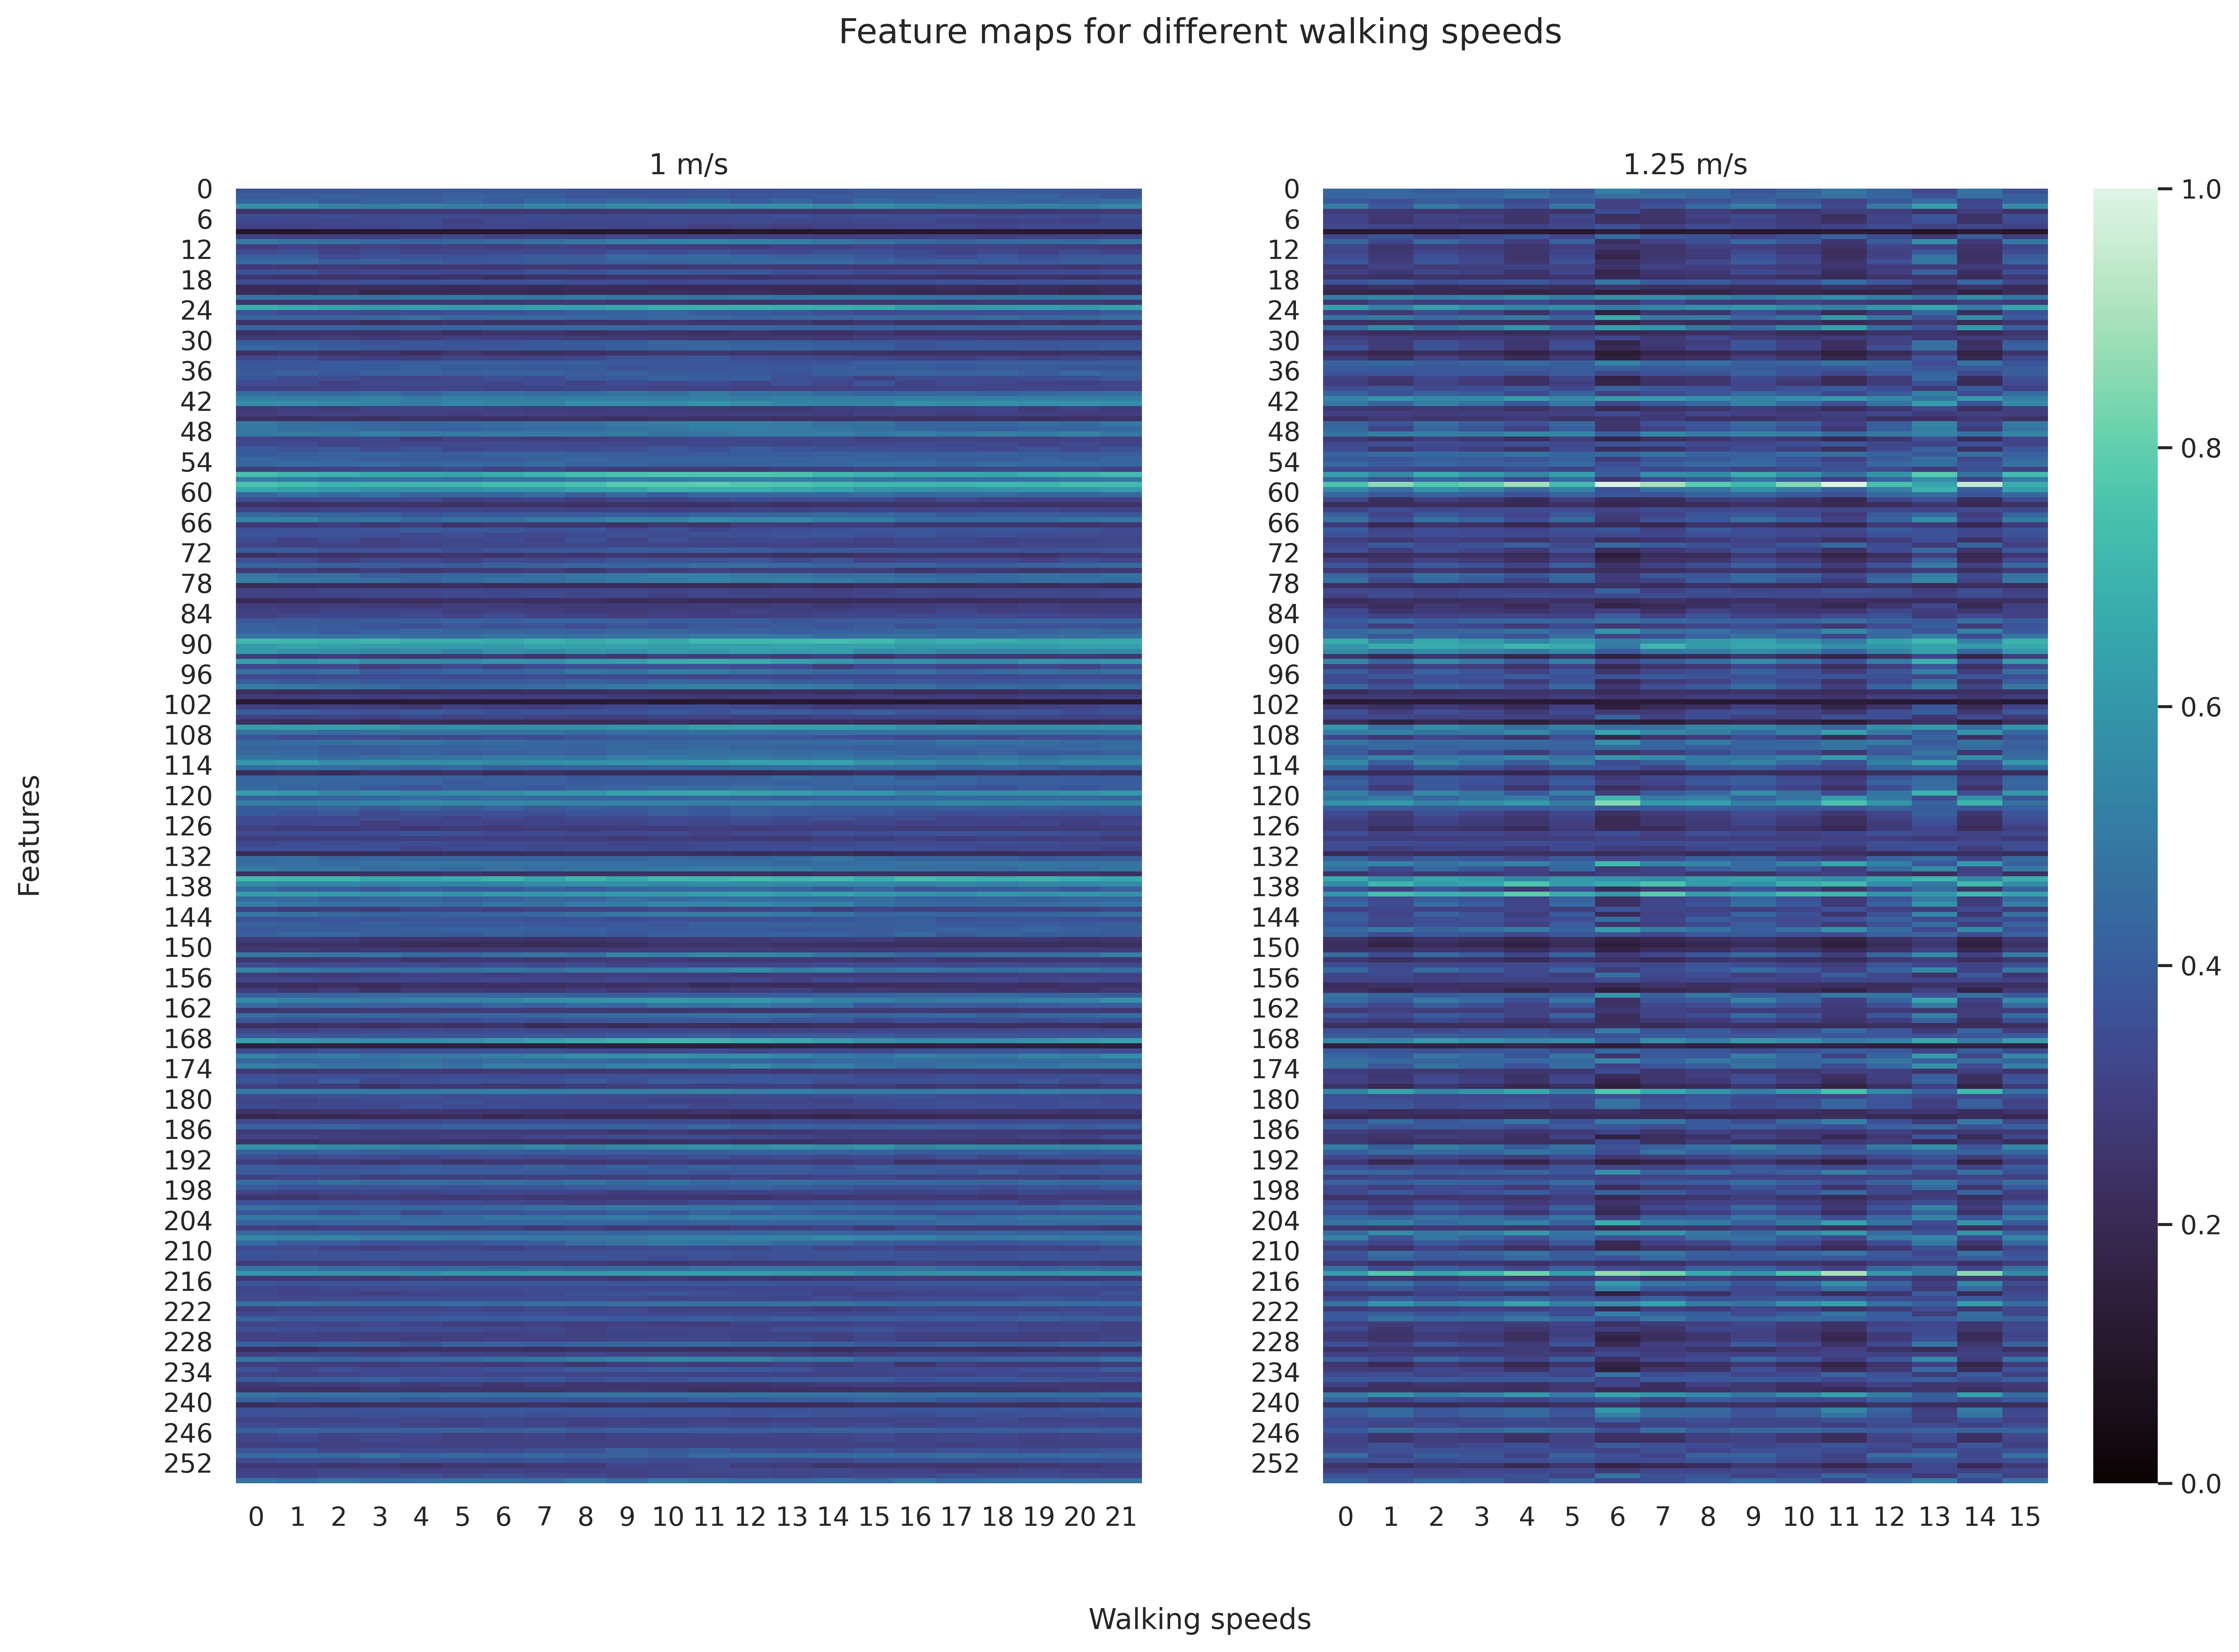

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (15,10))
colormap = sns.color_palette("mako", as_cmap=True)
fig.text(0.04, 0.5, ' Features', va='center', rotation='vertical')
fig.text(0.5,0.04,'Walking speeds',ha='center')
plt.suptitle('Feature maps for different walking speeds')
sns.set_theme(rc={"figure.dpi":500})

axes[0].set_title('1 m/s')
axes[1].set_title('1.25 m/s')
#axes[2].set_title('1.5 m/s')
sns.heatmap(l3_3,cmap=colormap,ax = axes[0],vmin=0,vmax=1,cbar=False)
sns.heatmap(a2_3,cmap=colormap,ax = axes[1],vmin=0,vmax=1)
#sns.heatmap(l4_3,cmap=colormap,ax = axes[2])
 